In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)
session

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
def calc_temps(start_date, end_date):
    """tmin, tavg, and tmax for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        tmin, tavg, and tmax
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2017-08-01', '2017-08-07'))
trip_result=calc_temps('2017-08-01', '2017-08-07')
year_list=[]
for tmin,tavg, tmax in trip_result:
    temp_list={}
    temp_list["tmin"]=tmin
    temp_list["tavg"]=tavg
    temp_list["tmax"]=tmax
    year_list.append(temp_list)
print(year_list)
    

[(72.0, 79.25, 83.0)]
[{'tmin': 72.0, 'tavg': 79.25, 'tmax': 83.0}]


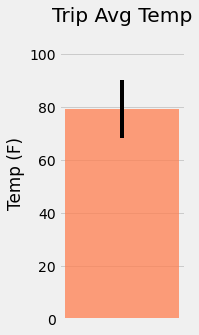

In [11]:
# Plot the results from your previous query as a bar chart. 
fig, ax = plt.subplots(figsize=(2, 5))
x_axis=np.arange(0,len(trip_result[0]))
# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
# Use the average temperature for bar height (y value)
y_value=tavg
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr=tmax-tmin
plt.bar(x_axis[0],y_value,yerr=yerr,facecolor="coral",alpha=0.75,align="center",width=0.15)
plt.xticks([])
# plt.xlim(-1, 1)
plt.ylim(0,110)
plt.savefig('Image/tripavgplot.png')
plt.show()


### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date='2017-08-01'
end_date='2017-08-07'

trip_prcp = session.query(Measurement.station, Station.name,
                          Station.latitude, Station.longitude, 
                          Station.elevation, func.sum(Measurement.prcp))\
                            .filter(Measurement.date >= start_date)\
                            .filter(Measurement.date <= end_date)\
                            .group_by(Measurement.station)\
                            .order_by(func.sum(Measurement.prcp).desc())\
                            .filter(Measurement.station == Station.station).all()
trip_df=pd.DataFrame(trip_prcp, columns=['Station ID', 
                                                'Name', 
                                                'Latitude', 
                                                'Longitude', 
                                                'Elevation', 
                                                'Total Precipitation'])
trip_df



,Station ID,Name,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date)
# Strip off the year and save a list of strings in the format %m-%d
trip_md_dates = [trip_dates[d].strftime("%m-%d")  for d in range(len(trip_dates))]
trip_md_dates

# Use the `daily_normals` function to calculate the normals for each date string 
# daily_normals(trip_md_dates[0])
# and append the results to a list called `normals`.
normals=[]
for md in range(len(trip_md_dates)):
    results_md=daily_normals(trip_md_dates[md])
    normals.append(results_md[0])
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


tmin_trip = [normals[tm][0] for tm in range(len(normals))]
tavg_trip = [normals[ta][1] for ta in range(len(normals))]
tmax_trip = [normals[tM][2] for tM in range(len(normals))]

Trip_temp_df = pd.DataFrame({
    'Date': trip_dates,
    'Tmin': tmin_trip,
    'Tavg': tavg_trip,
    'Tmax': tmax_trip
    
}).set_index('Date')

Trip_temp_df

,Tmin,Tavg,Tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


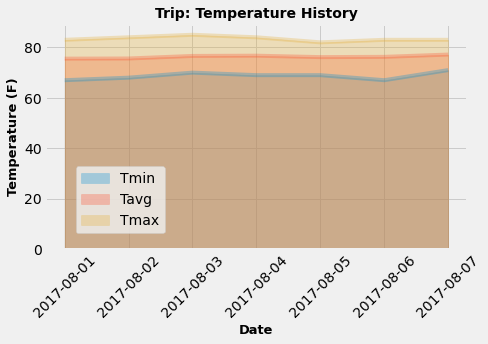

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
Trip_temp_df.plot(kind='area', stacked=False, rot=45, use_index=False, alpha=0.3, figsize=(7,5))
positions = list(np.arange(len(trip_dates)))
labels = trip_dates.strftime("%Y-%m-%d")
plt.xticks(positions, labels)
plt.xlabel('Date', fontweight='bold', fontsize=13)
plt.ylabel('Temperature (F)', fontweight='bold', fontsize=13)
plt.title('Trip: Temperature History', fontweight='bold', fontsize=14)
plt.legend(loc='best', bbox_to_anchor=(-0.2, -0.1, 0.5, 0.5))

# Save the figure and show
plt.tight_layout()
plt.savefig('Image/trip_plot.png')

plt.show()

## Close Session

In [17]:
session.close()